# General imports

In [1]:
import numpy as np

from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh

from multiview_mapping_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)

from multiview_mapping_toolkit.config import (
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_PREDICTED_LABELS_FOLDER,
    EXAMPLE_DTM_FILE,
    EXAMPLE_AGGREGATED_FACE_LABELS_FILE,
    EXAMPLE_PREDICTED_VECTOR_LABELS_FILE,
    EXAMPLE_LABEL_NAMES,
)

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-20 14:03:54:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpitco91wx


# Processing parameters

In [2]:
# Skip re-computing the aggregation and use a saved version
USE_CACHED_AGGREGATION = True
# Processing parameters
HEIGHT_ABOVE_GROUND_THRESH = 2  # Height above the DTM to consider not ground
MESH_DOWNSAMPLE_TARGET = 0.25  # Downsample the mesh to this fraction
AGGREGATE_IMAGE_SCALE = 0.25  # Aggregate images at this scale resolution
BUFFER_RADIUS_METER = 50  # Include cameras within this radius of labeled points

CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
MESH_FILENAME = EXAMPLE_MESH_FILENAME
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
PREDICTED_IMAGE_LABELS_FOLDER = EXAMPLE_PREDICTED_LABELS_FOLDER
DTM_FILE = EXAMPLE_DTM_FILE
AGGREGATED_FACE_LABELS_FILE = EXAMPLE_AGGREGATED_FACE_LABELS_FILE
LABEL_NAMES = EXAMPLE_LABEL_NAMES
PREDICTED_VECTOR_LABELS_FILE = EXAMPLE_PREDICTED_VECTOR_LABELS_FILE

# Load the mesh

In [3]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME, transform_filename=EXAMPLE_CAMERAS_FILENAME
)

# Load the camera set and subsample

In [4]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

Loading GPS data for camera set: 100%|██████████| 915/915 [00:00<00:00, 1842433.11it/s]


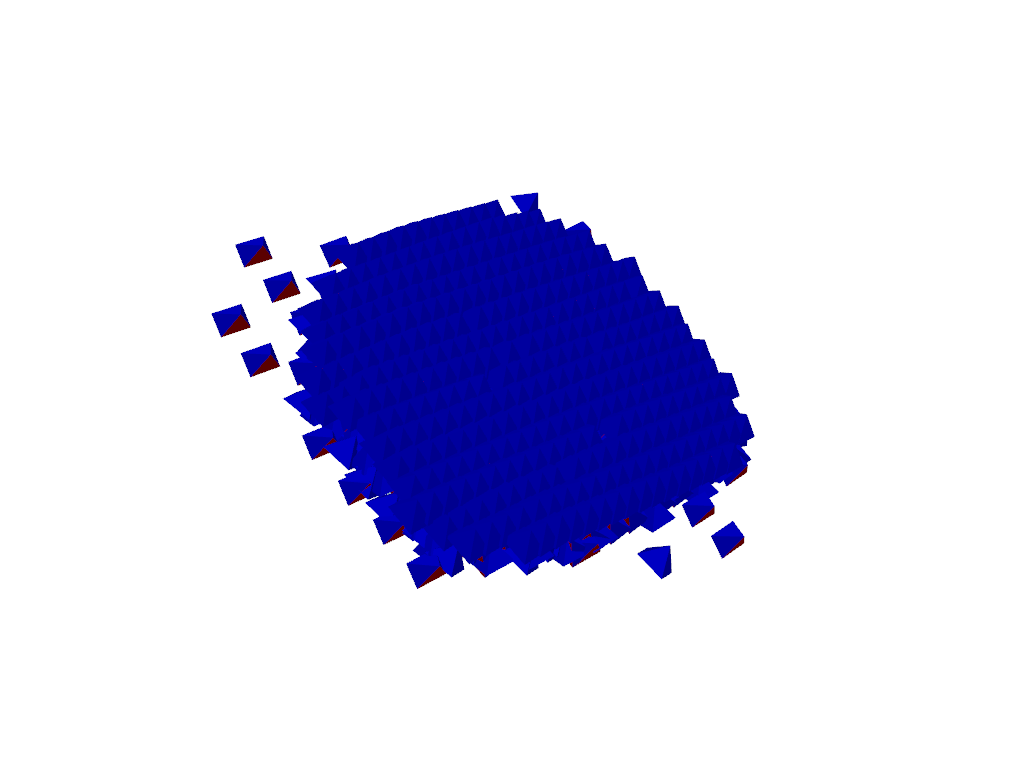

In [5]:
mesh.vis(camera_set=camera_set, force_xvfb=True)

In [6]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=len(LABEL_NAMES),
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

In [7]:
if USE_CACHED_AGGREGATION:
    aggregated_face_labels = np.load(AGGREGATED_FACE_LABELS_FILE)
else:
    aggregated_face_labels, _, _ = mesh.aggregate_viewpoints_pytorch3d(
        segmentor_camera_set,
        image_scale=AGGREGATE_IMAGE_SCALE,
    )
    np.save(AGGREGATED_FACE_LABELS_FILE, aggregated_face_labels)

In [8]:
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)

Sampling values from raster:   0%|          | 1792/705768 [00:00<00:41, 16953.75it/s]

Sampling values from raster: 100%|██████████| 705768/705768 [00:28<00:00, 25052.19it/s]


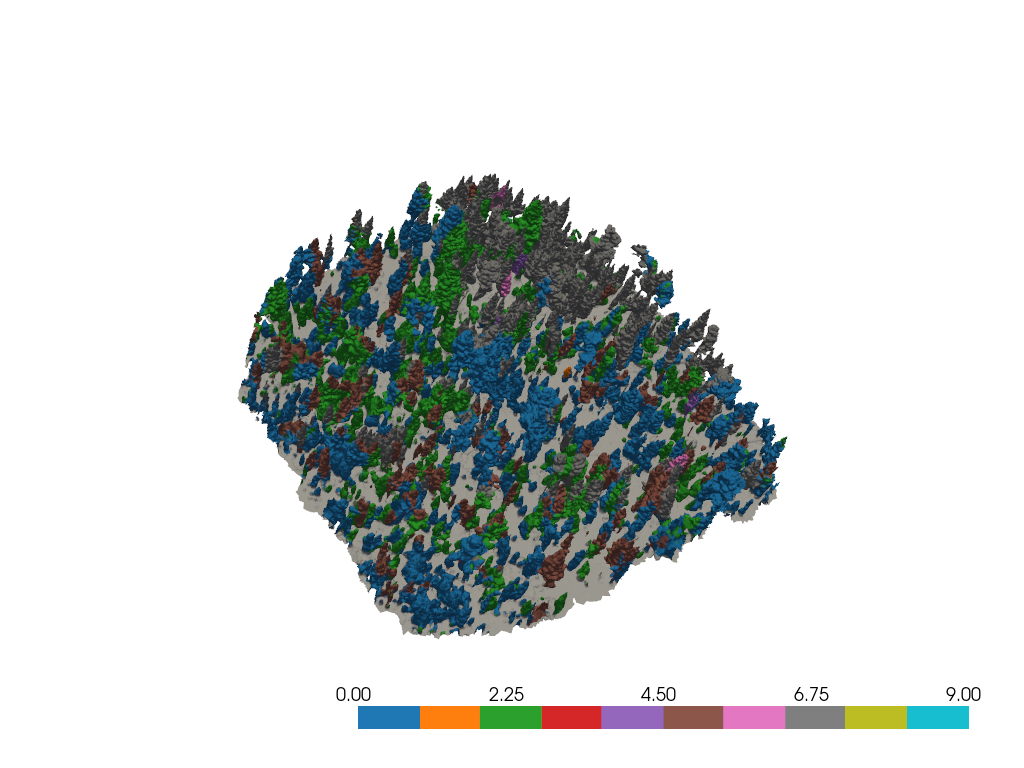

In [11]:
mesh.vis(
    vis_scalars=predicted_face_classes, mesh_kwargs={"cmap": "tab10", "clim": (0, 9)}
)

# Export the prediction to a vector file

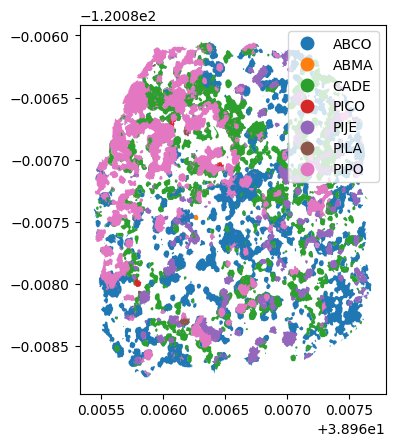

,class_id,geometry,names
0,0.0,"MULTIPOLYGON (((38.96549 -120.08801, 38.96549 ...",ABCO
1,1.0,"MULTIPOLYGON (((38.96618 -120.08759, 38.96618 ...",ABMA
2,2.0,"MULTIPOLYGON (((38.96553 -120.08806, 38.96553 ...",CADE
3,4.0,"MULTIPOLYGON (((38.96575 -120.08825, 38.96575 ...",PICO
4,5.0,"MULTIPOLYGON (((38.96569 -120.08828, 38.96570 ...",PIJE
5,6.0,"MULTIPOLYGON (((38.96581 -120.08726, 38.96581 ...",PILA
6,7.0,"MULTIPOLYGON (((38.96546 -120.08764, 38.96546 ...",PIPO


In [12]:
mesh.export_face_labels_vector(
    face_labels=np.squeeze(predicted_face_classes),
    export_file=PREDICTED_VECTOR_LABELS_FILE,
    label_names=EXAMPLE_LABEL_NAMES,
    vis=True,
    vis_kwargs={"cmap": "tab10", "vmin": 0, "vmax": 9},
)

# Compare the quality of the prediction with the ground truth

In [ ]:
from multiview_mapping_toolkit.utils.geospatial import (
    get_fractional_overlap,
)
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf

result, overlay, labeled_tree_data = get_fractional_overlap(
    species_gt_data, species_pred_data
)

ImportError: cannot import name 'get_fractional_overlap' from 'multiview_mapping_toolkit.utils.geospatial' (/ofo-share/repos-david/multiview-mapping-toolkit/multiview_mapping_toolkit/utils/geospatial.py)